In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [9]:
def fun(x):
    # the real function to estimate
    return 100 * (1.0 - np.exp(-4*x+3*x**3))

In [10]:
class BiddingEnvironment():
    def __init__(self, bids, sigma):
        self.bids = bids
        self.means = fun(bids)
        self.sigmas = np.ones(len(bids)) * sigma
    
    def round(self, pulled_arm):
        reward = np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm], 1)
        return reward

In [11]:
class Learner:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(0, n_arms)]
        self.collected_rewards = np.array([])
    
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)


In [12]:
class GTS_Learner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.means = np.zeros(n_arms)
        self.sigmas = np.ones(n_arms) * 1e3

        
    def pull_arm(self):
        idx = np.argmax(np.random.normal(self.means, self.sigmas))
        return idx 
     
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.means[pulled_arm] = np.mean(self.rewards_per_arm[pulled_arm])
        n_samples = len(self.rewards_per_arm[pulled_arm])
        if n_samples > 1:
            self.sigmas[pulled_arm] = np.std(self.rewards_per_arm[pulled_arm]) / n_samples

In [13]:
class GPTS_Learner(Learner):
    def __init__(self, n_arms, arms):
        super().__init__(n_arms)
        self.arms = arms
        self.means = np.zeros(n_arms)
        self.sigmas = np.ones(n_arms) * 10
        self.pulled_arms = []
        alpha = 10.0
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha = alpha**2, normalize_y=True, n_restarts_optimizer=10)

    
    def update_observations(self, pulled_arm, reward):
        super().update_observations(pulled_arm, reward)
        self.pulled_arms.append(self.arms[pulled_arm])
        
    def update_model(self):
        x = np.atleast_2d(self.pulled_arms).T
        y = self.collected_rewards
        self.gp.fit(x,y)
        
        x_pred = np.atleast_2d(self.arms).T
        self.means, self.sigmas = self.gp.predict(x_pred, return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-2)
        
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.update_model()
        
    
    def pull_arm(self):
        idx = np.argmax(np.random.normal(self.means, self.sigmas))
        return idx 


In [14]:
#Stationary Environment

n_arms = 20
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 10

T = 60
n_experiment = 10
gts_rewards_per_experiment = []
gpts_rewards_per_experiment = []


for e in range(0, n_experiment):
    env = BiddingEnvironment(bids=bids, sigma=sigma)
    gts_learner = GTS_Learner(n_arms=n_arms)
    gpts_learner = GPTS_Learner(n_arms=n_arms, arms=bids)

    for t in range(0, T):   
        
        #Gaussian Thompson Sampling Learner
        pulled_arm = gts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gts_learner.update(pulled_arm, reward)
        
        #Gaussian Process Thompson Sampling Learner
        pulled_arm = gpts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, reward)
        
       
        
    gts_rewards_per_experiment.append(gts_learner.collected_rewards)
    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)
    


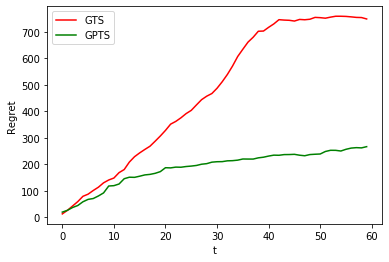

In [9]:
opt = np.max(env.means)
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - gts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis=0)), 'g')
plt.legend(["GTS", "GPTS"])
plt.show()

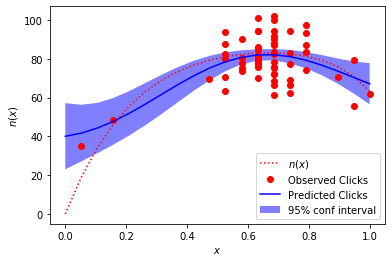

In [21]:
x_pred = np.atleast_2d(gpts_learner.arms).T
x = np.atleast_2d(gpts_learner.pulled_arms).T
y = gpts_learner.collected_rewards
plt.plot(x_pred, fun(x_pred), 'r:', label=r'$n(x)$')
plt.plot(x.ravel(), y, 'ro', label=u'Observed Clicks')
plt.plot(x_pred, gpts_learner.means, 'b-', label=u'Predicted Clicks')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([gpts_learner.means - 1.96*gpts_learner.sigmas, (gpts_learner.means + 1.96*gpts_learner.sigmas)[::-1]]),
         alpha = .5, fc='b', ec='None', label = '95% conf interval')
plt.xlabel('$x$')
plt.ylabel('$n(x)$')
plt.legend(loc='lower right')
plt.show()

In [15]:
env.sigmas

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10.])

In [15]:
opt = np.max(env.means)
opt

83.06715326138243

In [ ]:
opt = np.max(env.means)
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(gts_rewards_per_experiment, axis=0), 'r')
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis=0), 'g')
plt.legend(["GTS", "GPTS"])
plt.show()